In [1]:
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pylab as plt
# %matplotlib nbagg
# %matplotlib inline
import h5py
import json
import pickle

## Loading files

In [27]:
## Read all the training data and labels from h5 files
file = r'C:\LINHC\VersucheDBs\Trelleborg\test\training.h5'
f = h5py.File(file, 'r')

f = h5py.File(file, 'r')
print("ATTR:")
print(f.attrs.keys())
print("Keys:")
print('setup: ', f['setup'].keys())
print('liview: ', f['liview'].keys())

dataset = []
for i in range(121):
    dataset.append(f['liview']['s21'][i].real)
    dataset.append(f['liview']['s21'][i].imag)
    
X = np.asarray(dataset).T
X_t = X
y = np.asarray(f['setup']['ip1k1'])
y_t = np.asarray(f['setup']['k1t'])

print("X:")
print(X.shape)
print("y:")
print(y.shape)

ATTR:
<KeysViewHDF5 ['feature_lookup', 'name_lookup_rev']>
Keys:
setup:  <KeysViewHDF5 ['ip1k1', 'ip2k1', 'k1at', 'k1f', 'k1p', 'k1t', 'phi', 'pos1', 'spd1']>
liview:  <KeysViewHDF5 ['s21']>
X:
(92000, 242)
y:
(92000,)


In [3]:
# json.loads(f.attrs["feature_lookup"])

In [4]:
# json.loads(f.attrs["name_lookup_rev"])

## Plots to verify the training data

<IPython.core.display.Javascript object>


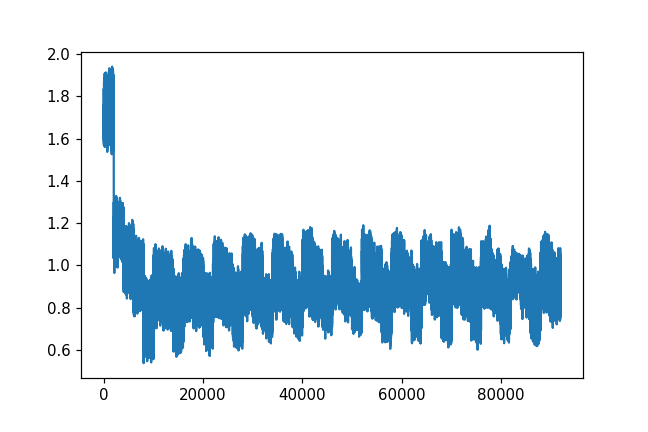

In [25]:
# plot y
plt.plot(y)

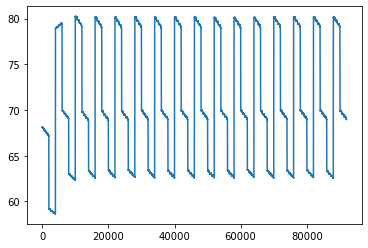

In [5]:
# plot temperatur
plt.plot(y_t )

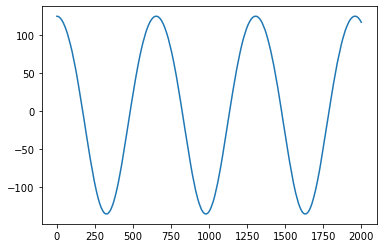

In [6]:
# y_test is not a sine wave because it's out of order and normalized.
plt.plot(f['setup']['pos1'][-2000:])

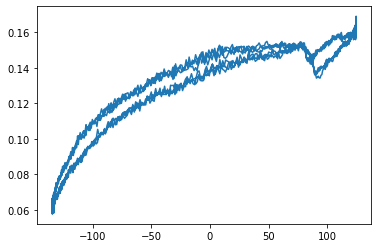

In [7]:
# s21 vs pos, freq 0,last lsa
%matplotlib inline
plt.plot(f['setup']['pos1'][-2000:],np.sqrt(X.T[0][-2000:]**2+X.T[1][-2000:]**2))

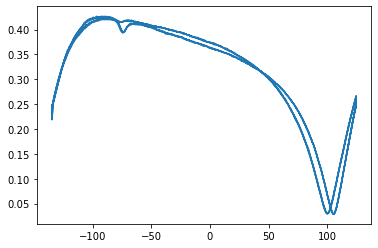

In [8]:
# s21 vs pos, freq 20, last lsa
plt.plot(f['setup']['pos1'][-2000:],np.sqrt(X.T[20][-2000:]**2+X.T[21][-2000:]**2))

## Data preprocessing

something else for imaginary number? maybe add abs as well?

In [9]:
# split the data: training, 80%; test, 20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(
    X_t, y_t, test_size=0.2, random_state=42
)

In [10]:
# Normalization: std, 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# following codes have the same effect
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

scaler_t = StandardScaler()
X_t_train_scaled = scaler_t.fit_transform(X_t_train)
X_t_test_scaled = scaler_t.transform(X_t_test)

## Training

### Random Forest

#### for ip1k1

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train) # training time for 100 trees is approx. 2 hours

RandomForestRegressor()

In [21]:
# save the file
filename = './models/rf_ip1k1.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [13]:
# # load the model from disk
# filename = './models/rf1.pkl'
# loaded_model = pickle.load(open(filename, 'rb'))

In [14]:
rf.score(X_test_scaled, y_test)

0.22995743401477575

median of the errors:  0.07740810364484785


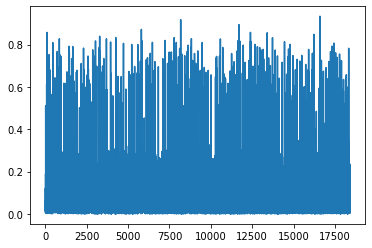

In [15]:
err = abs(rf.predict(X_test_scaled) - y_test)
print("median of the errors: ", np.median(err))
plt.plot(err)

In [17]:
# feature ranking
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_lookup_rev = {v: k for k, v in json.loads(f.attrs["feature_lookup"]).items()}
print("Feature ranking:")
for i in range(X_train_scaled.shape[1]):
    print("%d. feature %d, %s :(%f)" % 
          (i + 1, indices[i],feature_lookup_rev[indices[i]], importances[indices[i]]))

Feature ranking:
1. feature 8, s21-4-real :(0.025678)
2. feature 105, s21-52-imag :(0.024025)
3. feature 104, s21-52-real :(0.021670)
4. feature 97, s21-48-imag :(0.019151)
5. feature 9, s21-4-imag :(0.019012)
6. feature 95, s21-47-imag :(0.018722)
7. feature 96, s21-48-real :(0.017400)
8. feature 94, s21-47-real :(0.016142)
9. feature 21, s21-10-imag :(0.013938)
10. feature 0, s21-0-real :(0.013472)
11. feature 19, s21-9-imag :(0.012729)
12. feature 18, s21-9-real :(0.012598)
13. feature 101, s21-50-imag :(0.011638)
14. feature 20, s21-10-real :(0.011548)
15. feature 100, s21-50-real :(0.011352)
16. feature 106, s21-53-real :(0.010311)
17. feature 107, s21-53-imag :(0.010072)
18. feature 98, s21-49-real :(0.009911)
19. feature 1, s21-0-imag :(0.009869)
20. feature 102, s21-51-real :(0.009537)
21. feature 99, s21-49-imag :(0.008974)
22. feature 4, s21-2-real :(0.008435)
23. feature 3, s21-1-imag :(0.008414)
24. feature 7, s21-3-imag :(0.008168)
25. feature 103, s21-51-imag :(0.007937)


In [18]:
# print feature importance for setup features
# for i in range(X_train_scaled.shape[1]):
#     if indices[i]>241:
#         abbr = feature_lookup_rev[indices[i]]
#         print("%d. %s, %s :(%f)" % 
#               (i + 1, abbr,json.loads(f.attrs["name_lookup_rev"])[abbr], importances[indices[i]]))

<IPython.core.display.Javascript object>


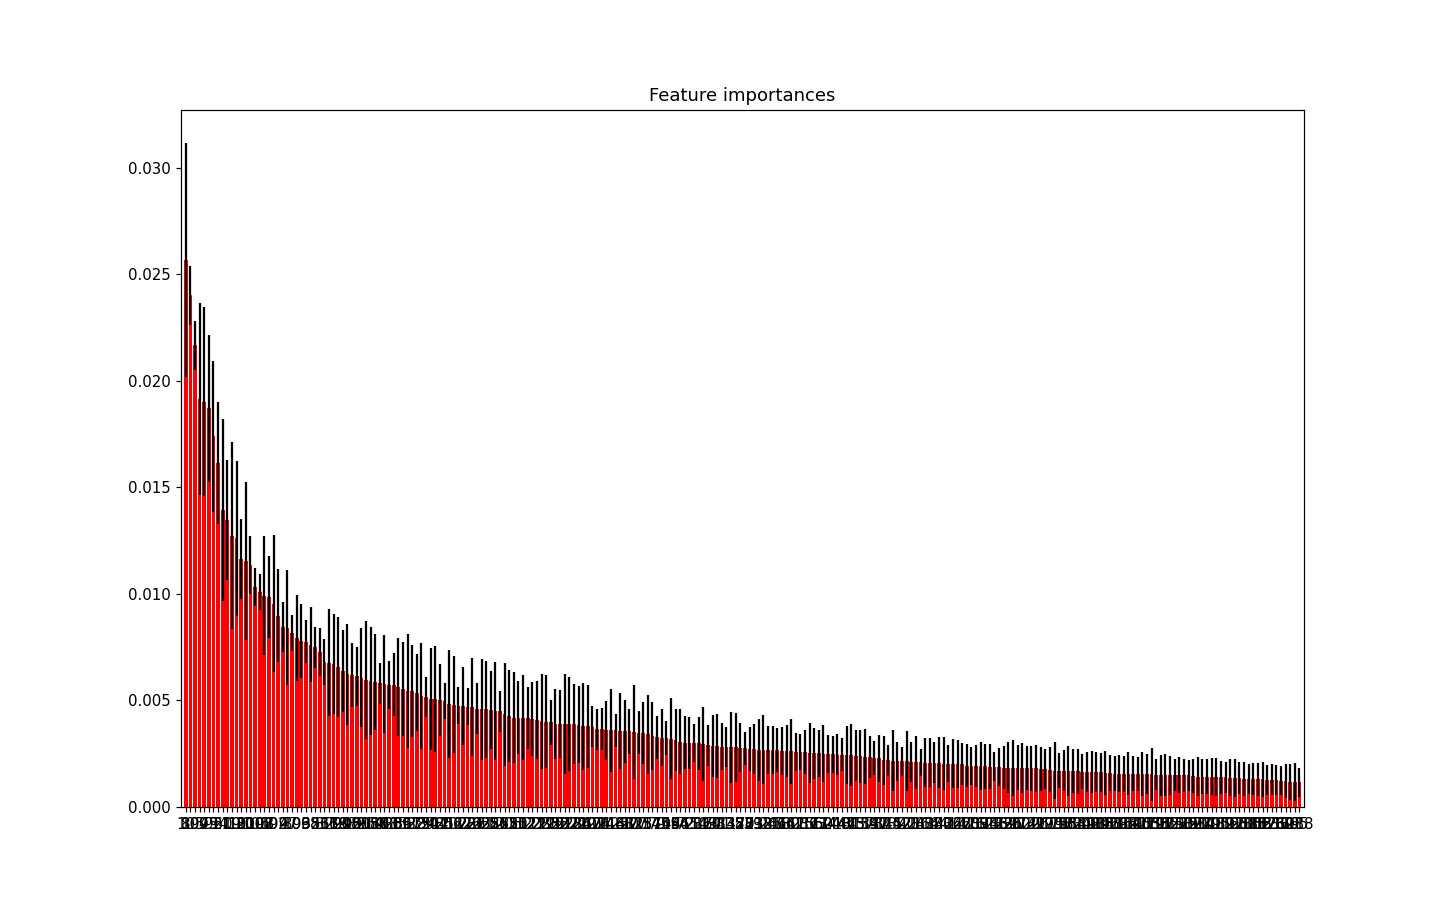

In [23]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot the impurity-based feature importances of the forest
%matplotlib nbagg
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

#### for temperature

In [33]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_t_train_scaled, y_t_train) # training time for 100 trees is approx. 2 hours

# save the file
filename = './models/rf_ip1k1.pkl'
pickle.dump(rf, open(filename, 'wb'))

# # load the model from disk
# filename = './models/rf_ip1k1.pkl'
# loaded_model = pickle.load(open(filename, 'rb'))

rf.score(X_t_test_scaled, y_t_test)

0.3627638621342332

In [35]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_lookup_rev = {v: k for k, v in json.loads(f.attrs["feature_lookup"]).items()}
print("Feature ranking:")
for i in range(X_train_scaled.shape[1]):
    print("%d. feature %d, %s :(%f)" % 
          (i + 1, indices[i],feature_lookup_rev[indices[i]], importances[indices[i]]))

ValueError: Not a location (invalid object ID)

In [ ]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Plot the impurity-based feature importances of the forest
%matplotlib nbagg
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

In [34]:
f.close()